In [164]:
# dowload before running

import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# comment this after frist run

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Preprocessing and Balance Analysis

### Loading datasets and joining them

In [166]:
df_true = pd.read_csv("./db/True.csv",sep=',')
df_false = pd.read_csv("./db/Fake.csv",sep=',')

In [167]:
df_true['real'] = 1
df_false['real'] = 0

In [168]:
df = pd.concat([df_true,df_false])
df = df.drop(['date'], axis=1) # Not relevant. Check reference for clarification.

In [169]:
df.head()

,title,text,subject,real
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


### Defining pre-processing function

When working with text-based classifiers, it's important to clear them of expressions and words that provide little to no context or relevant information for classification.
In this step, the text is converted to lowercase, stop words are removed and then the text is lemmatised.

In [170]:
def pre_process_text_fields(df, cols):
    pre_df = df.copy(deep=True)
    pre_df[cols] = pre_df[cols].apply(lambda x: x.apply(lambda x: x.lower())) # Juro que fui eu ue escrevi isso, tá dessa forma pq com usei cols ele pega a série ao invés da coluna então tem de passar outro apply pra pegar os valores
    # removing stopwords
    stop_words = set(stopwords.words('english'))
    pre_df[cols].apply(lambda x: x.apply(lambda x : str(' '.join([word for word in x.split() if word not in stop_words]))))
    # lemmitization
    lemmatizer = WordNetLemmatizer()
    pre_df[cols] = pre_df[cols].apply(lambda x: x.apply(lambda x: ' '.join([lemmatizer.lemmatize(p) for p in x.lower().split()])))

    return pre_df

In [171]:
df = pre_process_text_fields(df, ['title', 'text'])

### Removing Tag-Like String from Text Collumn

When first looking at the data, a tag-like phrase appeared in the text field - This 'tag' references the origin of the text, and will introduce bias if left in this field. 
As such, it'll be removed from the text collumn and a origin collumn will be created to store it for precaution.

In [172]:
df["origin"] = df["text"].apply(lambda x: x.split("-")[0])
df["text"] = df["text"].apply(lambda x: 
    x if len(x.split("-")) <= 1
    else x.split("-")[1]
)

## Distribution analysis

### Subject/Topic 

In order assure the model can be retrained and the dataset augmented with external data, a subject/topic generalization will be conducted. Keeping the process simple, the fake news are to be separated between world news and politic news to fit with the topics delineated in the real news.

In [173]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['text_len'] = df['text'].apply(lambda x: len(x))

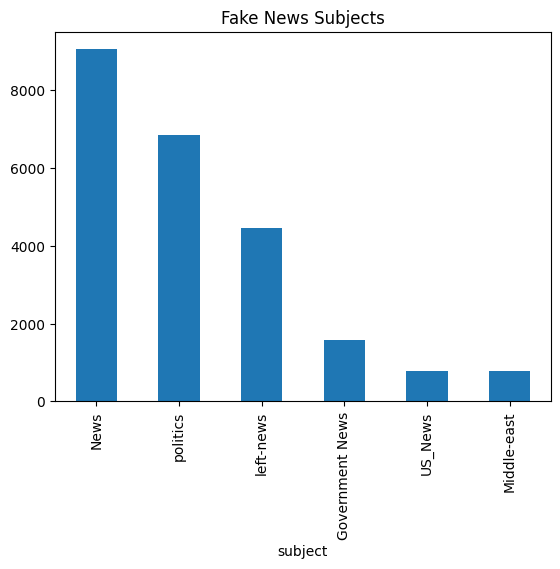

In [174]:
fake = df["real"] == 0
df[fake]["subject"].value_counts().plot(kind='bar')
plt.title("Fake News Subjects")
plt.show()

In [175]:
df['subject'] = df['subject'].apply(lambda x: 'politicsNews' if x in ['politics', 'left-news'] else x)
df['subject'] = df['subject'].apply(lambda x: 'worldnews' if x in ['News', 'Government News', 'US_News', 'Middle-east'] else x)

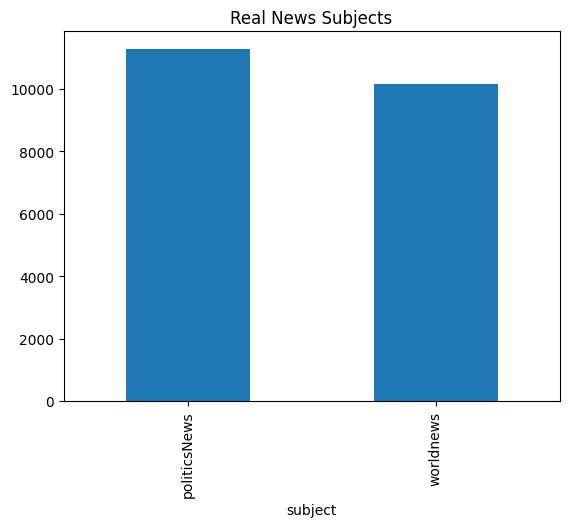

In [176]:
df[~fake]["subject"].value_counts().plot(kind='bar')
plt.title("Real News Subjects")
plt.show()

### Evaluating size distribution

This section has no impact in the final model. The goal is to check for other possible metrics to be used in future interations, such as text and title size.

<Axes: ylabel='Frequency'>

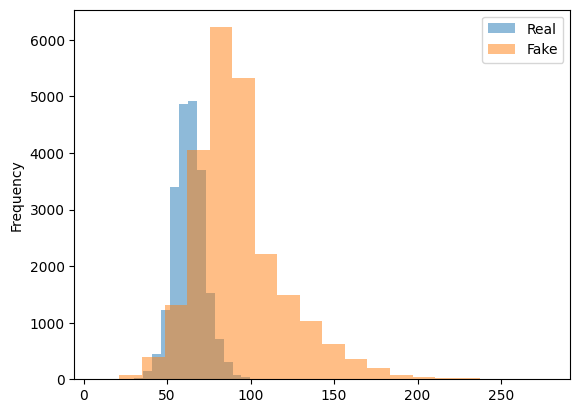

In [177]:
df[~fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)
df[fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)

<Axes: ylabel='Frequency'>

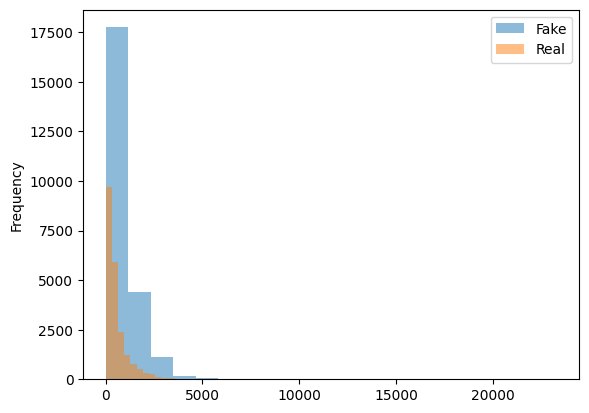

In [178]:
df[fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)
df[~fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)

### Target Feature Distribution

In [179]:
len(df[fake]), len(df[~fake])

(23481, 21417)

looks well balanced.

### Subject Split

In [180]:
world_news = df["subject"] == "worldnews"
politics_news = df["subject"] == "politicsNews"

df_world = df[world_news].copy(deep=True)
df_politics = df[politics_news].copy(deep=True)

### Down-Scaling Setup

To check for acuracy variation in different data sizes, an experiment comparing model performance using decreasing amounts of data will be conducted, with four smaller datasets being arranged to compare with the original.

In [181]:
# make me four dataframes for each subject, contaning respectively, 1/2 of the data, 1/4, 1/8 and 1/16 of the data, evenly balanced between real and fake news
# make sure to shuffle the data before splitting
df_world = df_world.sample(frac=1)
fake_index = df_world[df_world["real"] == 0].index
real_index = df_world[df_world["real"] == 1].index

df_world_1_2 = pd.concat([df_world.loc[fake_index[:len(fake_index)//2]], df_world.loc[real_index[:len(real_index)//2]]])
df_world_1_4 = pd.concat([df_world.loc[fake_index[:len(fake_index)//4]], df_world.loc[real_index[:len(real_index)//4]]])
df_world_1_8 = pd.concat([df_world.loc[fake_index[:len(fake_index)//8]], df_world.loc[real_index[:len(real_index)//8]]])
df_world_1_16 = pd.concat([df_world.loc[fake_index[:len(fake_index)//16]], df_world.loc[real_index[:len(real_index)//16]]])
df_world_1_32 = pd.concat([df_world.loc[fake_index[:len(fake_index)//32]], df_world.loc[real_index[:len(real_index)//32]]])
df_world_1_64 = pd.concat([df_world.loc[fake_index[:len(fake_index)//64]], df_world.loc[real_index[:len(real_index)//64]]])

In [182]:
df_politics = df_politics.sample(frac=1)
fake_index = df_politics[df_politics["real"] == 0].index
real_index = df_politics[df_politics["real"] == 1].index

df_politics_1_2 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//2]], df_politics.loc[real_index[:len(real_index)//2]]])
df_politics_1_4 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//4]], df_politics.loc[real_index[:len(real_index)//4]]])
df_politics_1_8 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//8]], df_politics.loc[real_index[:len(real_index)//8]]])
df_politics_1_16 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//16]], df_politics.loc[real_index[:len(real_index)//16]]])
df_politics_1_32 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//32]], df_politics.loc[real_index[:len(real_index)//32]]])
df_politics_1_64 = pd.concat([df_politics.loc[fake_index[:len(fake_index)//64]],df_politics.loc[real_index[:len(real_index)//64]]])

## Classifier Evaluation and Testing

In this section contains the pipeline related setups, testing with subject-based sections and downsampling tests.

### Pipeline Setup

In [183]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [184]:
def new_pipeline():
    return Pipeline([
        ('Vectorizer', CountVectorizer(binary=True)),  
        ('Classifier', LogisticRegression()),  
    ])

In [185]:
# define preprocessing pipeline
pipe_base = new_pipeline()

### Metric Extraction Setup

In [195]:
def relevant_words_sample(vectorizer, classifier):
    words = vectorizer.get_feature_names_out()
    coefs = classifier.coef_
    # classes = classifier.classes_
    sorted_coef_indexes = coefs.argsort(axis=1)


    print('\n')
    print(f"Most relevant for class: '0'\n")
    top5words = words[sorted_coef_indexes[0,:20]]
    print(top5words)
    top5coefs = coefs[0,sorted_coef_indexes[0,:10]]
    print(top5coefs)
    print('\n')
    print(f"Most relevant for class: '1'\n")
    last5words = words[sorted_coef_indexes[0,-20:]]
    print(last5words)
    last5coefs = coefs[0,sorted_coef_indexes[0,-10:]]
    print(last5coefs)


In [194]:
def test_pipeline(df, pipe, title):
    X_train, X_test, y_train, y_test = train_test_split(df["text"], df["real"], test_size=0.2)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(title, df.shape)
    print(classification_report(y_test, y_pred))

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Subject restricted classification

In [196]:
test_pipeline(df, pipe_base, "Complete Dataset")

Complete Dataset (44898, 7)
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4690
           1       0.97      0.94      0.95      4290

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [197]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['via' 'elect' 'rep' 'gop' 'mr' 'sen' 'https' 'gov' 'wing' 'ky' 'read'
 'obama' 'trump' 'com' 'controlled' 'finally' 'based' 'runner' 'watch'
 'assad']
[-3.62657018 -3.05749334 -2.83860215 -2.79928337 -2.50589678 -2.40373252
 -2.12733647 -2.03751283 -1.98921668 -1.97564537]


Most relevant for class: '1'

['pakistan' 'presidential' 'turkish' 'representative' 'french' 'catalonia'
 'tuesday' 'inc' 'monday' 'german' 'thursday' 'britain' 'wednesday' 'saad'
 'saudi' 'president' 'reuters' 'donald' 'est' 'edt']
[2.24109376 2.4264188  2.43506151 2.45558854 2.45809053 2.846959
 3.17196213 3.22216998 3.48201383 3.99021001]


In [198]:
test_pipeline(df_world, pipe_base, "Complete World News Dataset")

Complete World News Dataset (22326, 7)
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2426
           1       0.97      0.95      0.96      2040

    accuracy                           0.96      4466
   macro avg       0.96      0.96      0.96      4466
weighted avg       0.96      0.96      0.96      4466



In [199]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['trump' 'obama' 'wing' 'year' 'elect' 'via' 'republican' 'clinton'
 'american' 'america' 'according' 'page' 'based' 'morning' 'just' 'states'
 'gop' 'as' 'so' 'semitism']
[-2.53852782 -2.51729934 -2.09071817 -2.00692302 -1.88306794 -1.80921405
 -1.73903748 -1.57686905 -1.53672225 -1.39731435]


Most relevant for class: '1'

['russian' 'friday' 'european' 'wednesday' 'monday' 'britain' 'british'
 'china' 'minister' 'saad' 'australia' 'kurdish' 'thursday' 'italy'
 'german' 'french' 'japan' 'donald' 'reuters' 'saudi']
[1.87059977 1.88236084 1.90487979 1.90841591 1.91836442 1.93161946
 2.02588033 2.06932092 2.08713351 2.51533407]


In [200]:
test_pipeline(df_politics, pipe_base, "Complete Politics News Dataset")

Complete Politics News Dataset (22572, 7)
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2301
           1       0.97      0.93      0.95      2214

    accuracy                           0.95      4515
   macro avg       0.95      0.95      0.95      4515
weighted avg       0.95      0.95      0.95      4515



In [201]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['via' 'elect' 'rep' 'gop' 'read' 'mr' 'https' 'watch' 'sen' 'com' 'cnn'
 'gov' 'yes' 'finally' 'just' 'trumper' 'profile' 'pretty' 'insisted'
 'mccain']
[-3.75643606 -2.61110515 -2.59503823 -2.38215898 -2.23662999 -2.22084516
 -1.99938334 -1.96054218 -1.77674108 -1.60327977]


Most relevant for class: '1'

['nov' 'illinois' 'corp' 'tax' 'inc' 'thursday' 'tuesday' 'friday'
 'briefing' 'monday' 'lawmaker' 'representative' 'wednesday'
 'presidential' 'republican' 'donald' 'reuters' 'est' 'president' 'edt']
[1.83073773 1.90664181 1.99628444 2.30301    2.42424912 2.75216209
 2.75834595 3.08316811 3.27161917 4.00343858]


#### Preliminary Conclusion: 

Sectioning the data between subjects does not appear to have significative impact in the models accuracy for this dataset.

### Impacts of size reduction

In [214]:
test_pipeline(df_world_1_64, pipe_base, 'world 1/64')

world 1/64 (396, 7)
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        50
           1       0.76      0.87      0.81        30

    accuracy                           0.85        80
   macro avg       0.84      0.85      0.84        80
weighted avg       0.86      0.85      0.85        80



In [216]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['at' 'our' 'they' 'is' 'the' 'you' 'who' 'what' 'her' 'me' 'be' 'him'
 'about' 'well' 'she' 'read' 'this' 'get' 'great' 'all']
[-0.55514683 -0.52900102 -0.51847253 -0.50989656 -0.50590046 -0.48661763
 -0.4654404  -0.45602126 -0.41878499 -0.41420499]


Most relevant for class: '1'

['senate' 'put' 'government' 'ted' 'cruz' 'will' 'ha' 'lawmaker'
 'wednesday' 'democratic' 'state' 'thursday' 'during' 'tuesday' 'said'
 'front' 'republican' 'donald' 'on' 'president']
[0.59208518 0.59303846 0.60395465 0.67763169 0.8865314  0.91473282
 1.0308655  1.08128377 1.43104816 1.55066701]


In [206]:
test_pipeline(df_world_1_32, pipe_base, 'world 1/32')

politic 1/32 (785, 7)
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        81
           1       0.95      0.93      0.94        76

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157



In [207]:
test_pipeline(df_world_1_16, pipe_base, 'world 1/16')

politic 1/16 (1594, 7)
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       170
           1       0.94      0.93      0.93       149

    accuracy                           0.94       319
   macro avg       0.94      0.94      0.94       319
weighted avg       0.94      0.94      0.94       319



In [217]:
test_pipeline(df_world_1_8, pipe_base, 'world 1/8')

world 1/8 (3192, 7)
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       347
           1       0.95      0.92      0.94       292

    accuracy                           0.95       639
   macro avg       0.95      0.94      0.94       639
weighted avg       0.95      0.95      0.95       639



In [218]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['trump' 'year' 'american' 'republican' 'obama' 'just' 'before' 'right'
 'all' 'this' 'clinton' 'white' 'campaign' 'federal' 'think' 'about'
 'that' 'so' 'america' 'washington']
[-1.48559216 -1.27016932 -1.17765257 -1.13337908 -1.00188452 -0.98774241
 -0.98370708 -0.91146819 -0.87052768 -0.85742414]


Most relevant for class: '1'

['tuesday' 'prime' 'european' 'president' 'killed' 'austria' 'thursday'
 'long' 'on' 'friday' 'britain' 'far' 'reuters' 'minister' 'china' 'al'
 'wednesday' 'saudi' 'german' 'said']
[1.15169806 1.16650443 1.17722626 1.18996601 1.20667387 1.2192888
 1.36248334 1.38786584 1.40117303 1.46640529]


In [219]:
test_pipeline(df_politics_1_64, pipe_base, 'politics 1/64')

politics 1/64 (412, 7)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.90      0.85      0.88        41

    accuracy                           0.88        83
   macro avg       0.88      0.88      0.88        83
weighted avg       0.88      0.88      0.88        83



In [220]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['but' 'the' 'our' 'you' 'him' 'america' 'her' 'what' 'who' 'american'
 'that' 'life' 'they' 'is' 'well' 'me' 'at' 'we' 'ky' 'so']
[-0.66926992 -0.6406704  -0.59405002 -0.582299   -0.57045707 -0.52203845
 -0.50818366 -0.48838528 -0.48781066 -0.46363792]


Most relevant for class: '1'

['election' 'law' 'white' 'cruz' 'ted' 'will' 'democrat' 'to' 'democratic'
 'thursday' 'donald' 'state' 'tuesday' 'last' 'lawmaker' 'republican'
 'front' 'said' 'on' 'president']
[0.63600839 0.67319374 0.69160335 0.73999054 0.86242471 0.87882896
 0.88641036 1.12476189 1.25628289 1.83696717]


In [209]:
test_pipeline(df_politics_1_32, pipe_base, 'politics 1/32')

politics 1/32 (836, 7)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        75
           1       0.92      0.85      0.88        93

    accuracy                           0.88       168
   macro avg       0.87      0.88      0.87       168
weighted avg       0.88      0.88      0.88       168



In [210]:
test_pipeline(df_politics_1_16, pipe_base, 'politics 1/16')

politics 1/16 (1675, 7)
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       162
           1       0.89      0.88      0.89       173

    accuracy                           0.88       335
   macro avg       0.88      0.88      0.88       335
weighted avg       0.88      0.88      0.88       335



In [211]:
test_pipeline(df_politics_1_8, pipe_base, 'politics 1/8')

politics 1/8 (3374, 7)
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       333
           1       0.93      0.89      0.91       342

    accuracy                           0.91       675
   macro avg       0.91      0.91      0.91       675
weighted avg       0.91      0.91      0.91       675



In [213]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: '0'

['trump' 'obama' 'year' 'american' 'republican' 'just' 'right' 'before'
 'america' 'that' 'campaign' 'you' 'this' 'clinton' 'here' 'think' 'white'
 'read' 'about' 'so']
[-1.56646599 -1.34067751 -1.33132571 -1.11894415 -1.09860467 -0.94313204
 -0.90177021 -0.88619052 -0.8239332  -0.78531546]


Most relevant for class: '1'

['police' 'south' 'thursday' 'prime' 'on' 'oil' 'center' 'country' 'long'
 'britain' 'china' 'reuters' 'friday' 'germany' 'german' 'al' 'wednesday'
 'minister' 'said' 'far']
[1.11712119 1.20040401 1.2166973  1.24840477 1.29350681 1.30036752
 1.34356229 1.34377626 1.37778674 1.47406716]
